# Time Series Pattern Analysis: Visualizing Dynamic Relationships in Sequential Data

## Overview
This notebook provides tools for analyzing and visualizing patterns in time series data by examining 
the relationships between consecutive data points. The core technique used is the Joint Interval 
Distribution (JID) approach, which pairs sequential data points to reveal underlying dynamics 
and patterns that might not be visible in traditional time series analysis.

## Purpose
The visualizations in this notebook help to:
1. Understand how consecutive data points relate to each other
2. Identify recurring patterns and trajectories in time series data
3. Visualize the flow and evolution of data points through time
4. Create dynamic representations of time series behavior

## Key Techniques
- **Line Tail Animation**: Visualizes the trajectory of data points with a trailing effect
- **Flow Field Analysis**: Maps the velocity and direction of data movement in phase space
- **Joint Interval Distribution (JID)**: Creates heatmaps showing the frequency distribution of consecutive values

In [12]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from collections import deque
from matplotlib.animation import PillowWriter
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

In [10]:
# Generate some sample data - a sine wave with noise
x = np.linspace(0, 20, 1000)
data = np.sin(x) + np.random.normal(0, 0.1, 1000)

## Line Tail

In [9]:
def create_linetail_animation(data, 
                              output_filename='linetail.gif',
                              tail_length=10, 
                              step_size=200, 
                              fps=5,
                              normalize_data=False):
    """
    Create an animated trajectory visualization of sequential data points.
    
    Parameters:
    -----------
    data : array-like
        The sequential data to visualize as a trajectory.
    output_filename : str, default='linetail.gif'
        Filename for the output GIF.
    tail_length : int, default=10
        Number of previous points to show in the trail.
    step_size : int, default=200
        Step size for sampling data points (higher = faster animation).
    fps : int, default=5
        Frames per second in the output animation.
    normalize_data : bool, default=False
        Whether to normalize the data to 0-1 range.
        
    Returns:
    --------
    None
        Saves the animation to the specified output filename.
    """

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_facecolor('#f0f0f0')
    fig.patch.set_facecolor('white')
    
    # Normalize data if requested
    if normalize_data:
        data_min = np.min(data)
        data_max = np.max(data)
        data_range = data_max - data_min
        normalized_data = (data - data_min) / data_range
    else:
        normalized_data = data
    
    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Customize the grid
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title('Data Point Trajectory', fontsize=14, pad=20)
    ax.set_xlabel('Data Point (n)', fontsize=12)
    ax.set_ylabel('Data Point (n+1)', fontsize=12)
    
    # Initialize longer tail for better trajectory visualization
    x_data = deque(maxlen=tail_length)
    y_data = deque(maxlen=tail_length)
    
    # Create color gradient for tail
    colors = plt.cm.viridis(np.linspace(0, 1, tail_length))
    
    # Initialize points and segments
    point = ax.plot([], [], 'o', color='darkred', markersize=12, label='Current Point')[0]
    segments = [ax.plot([], [], '-', color=colors[i], 
                       linewidth=2+2*i/tail_length, alpha=0.5)[0] 
               for i in range(tail_length-1)]
    
    def init():
        point.set_data([], [])
        for segment in segments:
            segment.set_data([], [])
        return [point] + segments
    
    def update(frame):
        start = frame * step_size
        
        if start + 1 < len(normalized_data):
            # Get current and next values
            x = normalized_data[start]
            y = normalized_data[start + 1]
            
            # Add new points to the tail
            x_data.append(x)
            y_data.append(y)
            
            # Update current point
            point.set_data([x], [y])
            
            # Update tail segments with gradient
            for i in range(len(segments)):
                if len(x_data) > i+1:
                    segments[i].set_data(
                        [x_data[-(i+2)], x_data[-(i+1)]],
                        [y_data[-(i+2)], y_data[-(i+1)]]
                    )
        
        # Add frame counter
        ax.set_title(f'Data Point Trajectory - Frame {frame+1}/{frames}', 
                    fontsize=14, pad=20)
        
        return [point] + segments
    
    # Create the animation
    frames = (len(normalized_data) - 2) // step_size
    if frames <= 0:
        raise ValueError("Not enough data points for animation with current step size")
    
    anim = FuncAnimation(fig, update, init_func=init,
                        frames=frames, interval=1000//fps, blit=False)
    
    # Add legend
    ax.legend(loc='upper right')
    
    # Save the animation
    anim.save(output_filename, writer='pillow', fps=fps, dpi=150)
    plt.close(fig)
    
    print(f"Animation saved as {output_filename}")

In [30]:
# Use the function
create_linetail_animation(data)

Animation saved as linetail.gif


This Line Tail visualisation transforms time series data into a dynamic phase space representation by plotting each data point against its immediate successor (value at time n versus value at time n+1), creating a coordinate system that reveals relationship patterns impossible to see in traditional time series plots. As the animation progresses, it traces the trajectory of these paired values with a colour-gradient tail that shows the recent path through this phase space, immediately making recurring patterns, cyclical behaviours, and transition zones apparent to viewers. This technique is particularly valuable for analysing complex systems like psychological or physiological data streams, where subtle regime shifts, attractor states, and behavioural changes must be identified. Viewers should gain insight into how the system evolves from one state to another over time, enabling them to identify stable patterns, unusual transitions, and the overall dynamic structure governing the time series. Visualisation is a powerful tool for hypothesis generation about underlying mechanisms, as regions where the trajectory moves quickly or slowly or areas it visits frequently or avoids entirely can reveal fundamental properties about the system being studied.

## Flow Fields

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

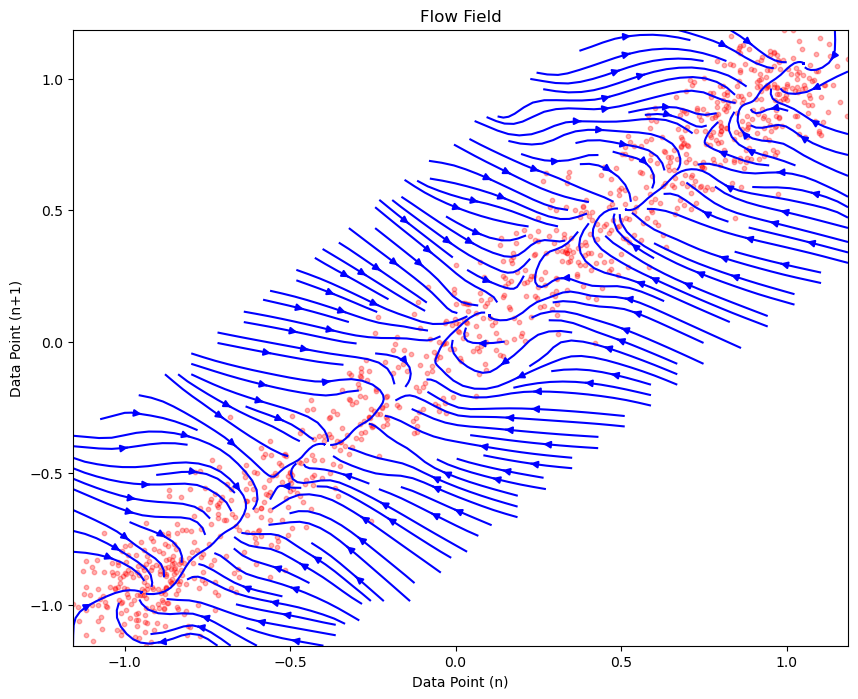

In [15]:
def create_phase_space(data, delay=1):
    # Create pairs of consecutive values
    x = data[:-delay]
    y = data[delay:]
    return x, y

def create_flow_field(data, grid_size=30, smoothing=0.5):
    # Create grid
    x = np.linspace(min(data), max(data), grid_size)
    y = np.linspace(min(data), max(data), grid_size)
    X, Y = np.meshgrid(x, y)
    
    # Get consecutive pairs
    data_x, data_y = create_phase_space(data)
    
    # Calculate velocities from actual data transitions
    dx = np.diff(data_x)  # Change in x
    dy = np.diff(data_y)  # Change in y
    
    # Points where we know the velocities
    points = np.column_stack((data_x[:-1], data_y[:-1]))
    
    # Interpolate velocities to our grid
    U = griddata(points, dx, (X, Y), method='cubic', fill_value=0)
    V = griddata(points, dy, (X, Y), method='cubic', fill_value=0)
    
    # Apply smoothing to reduce noise
    U = gaussian_filter(U, smoothing)
    V = gaussian_filter(V, smoothing)
    # Normalize velocities (optional)
    magnitude = np.sqrt(U**2 + V**2)
    magnitude[magnitude == 0] = 1  # Avoid division by zero
    U = U/magnitude
    V = V/magnitude
    
    # Create plot
    plt.figure(figsize=(10, 8))
    plt.streamplot(X, Y, U, V, color='blue', density=2)
    plt.xlabel('Data Point (n)')
    plt.ylabel('Data Point (n+1)')
    plt.title('Flow Field')
    
    return plt

def flowfield(data):
    x, y = create_phase_space(data)
    plt = create_flow_field(data)
    plt.scatter(x, y, color='red', alpha=0.3, s=10)
    return plt

# Use the function
flowfield(data)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

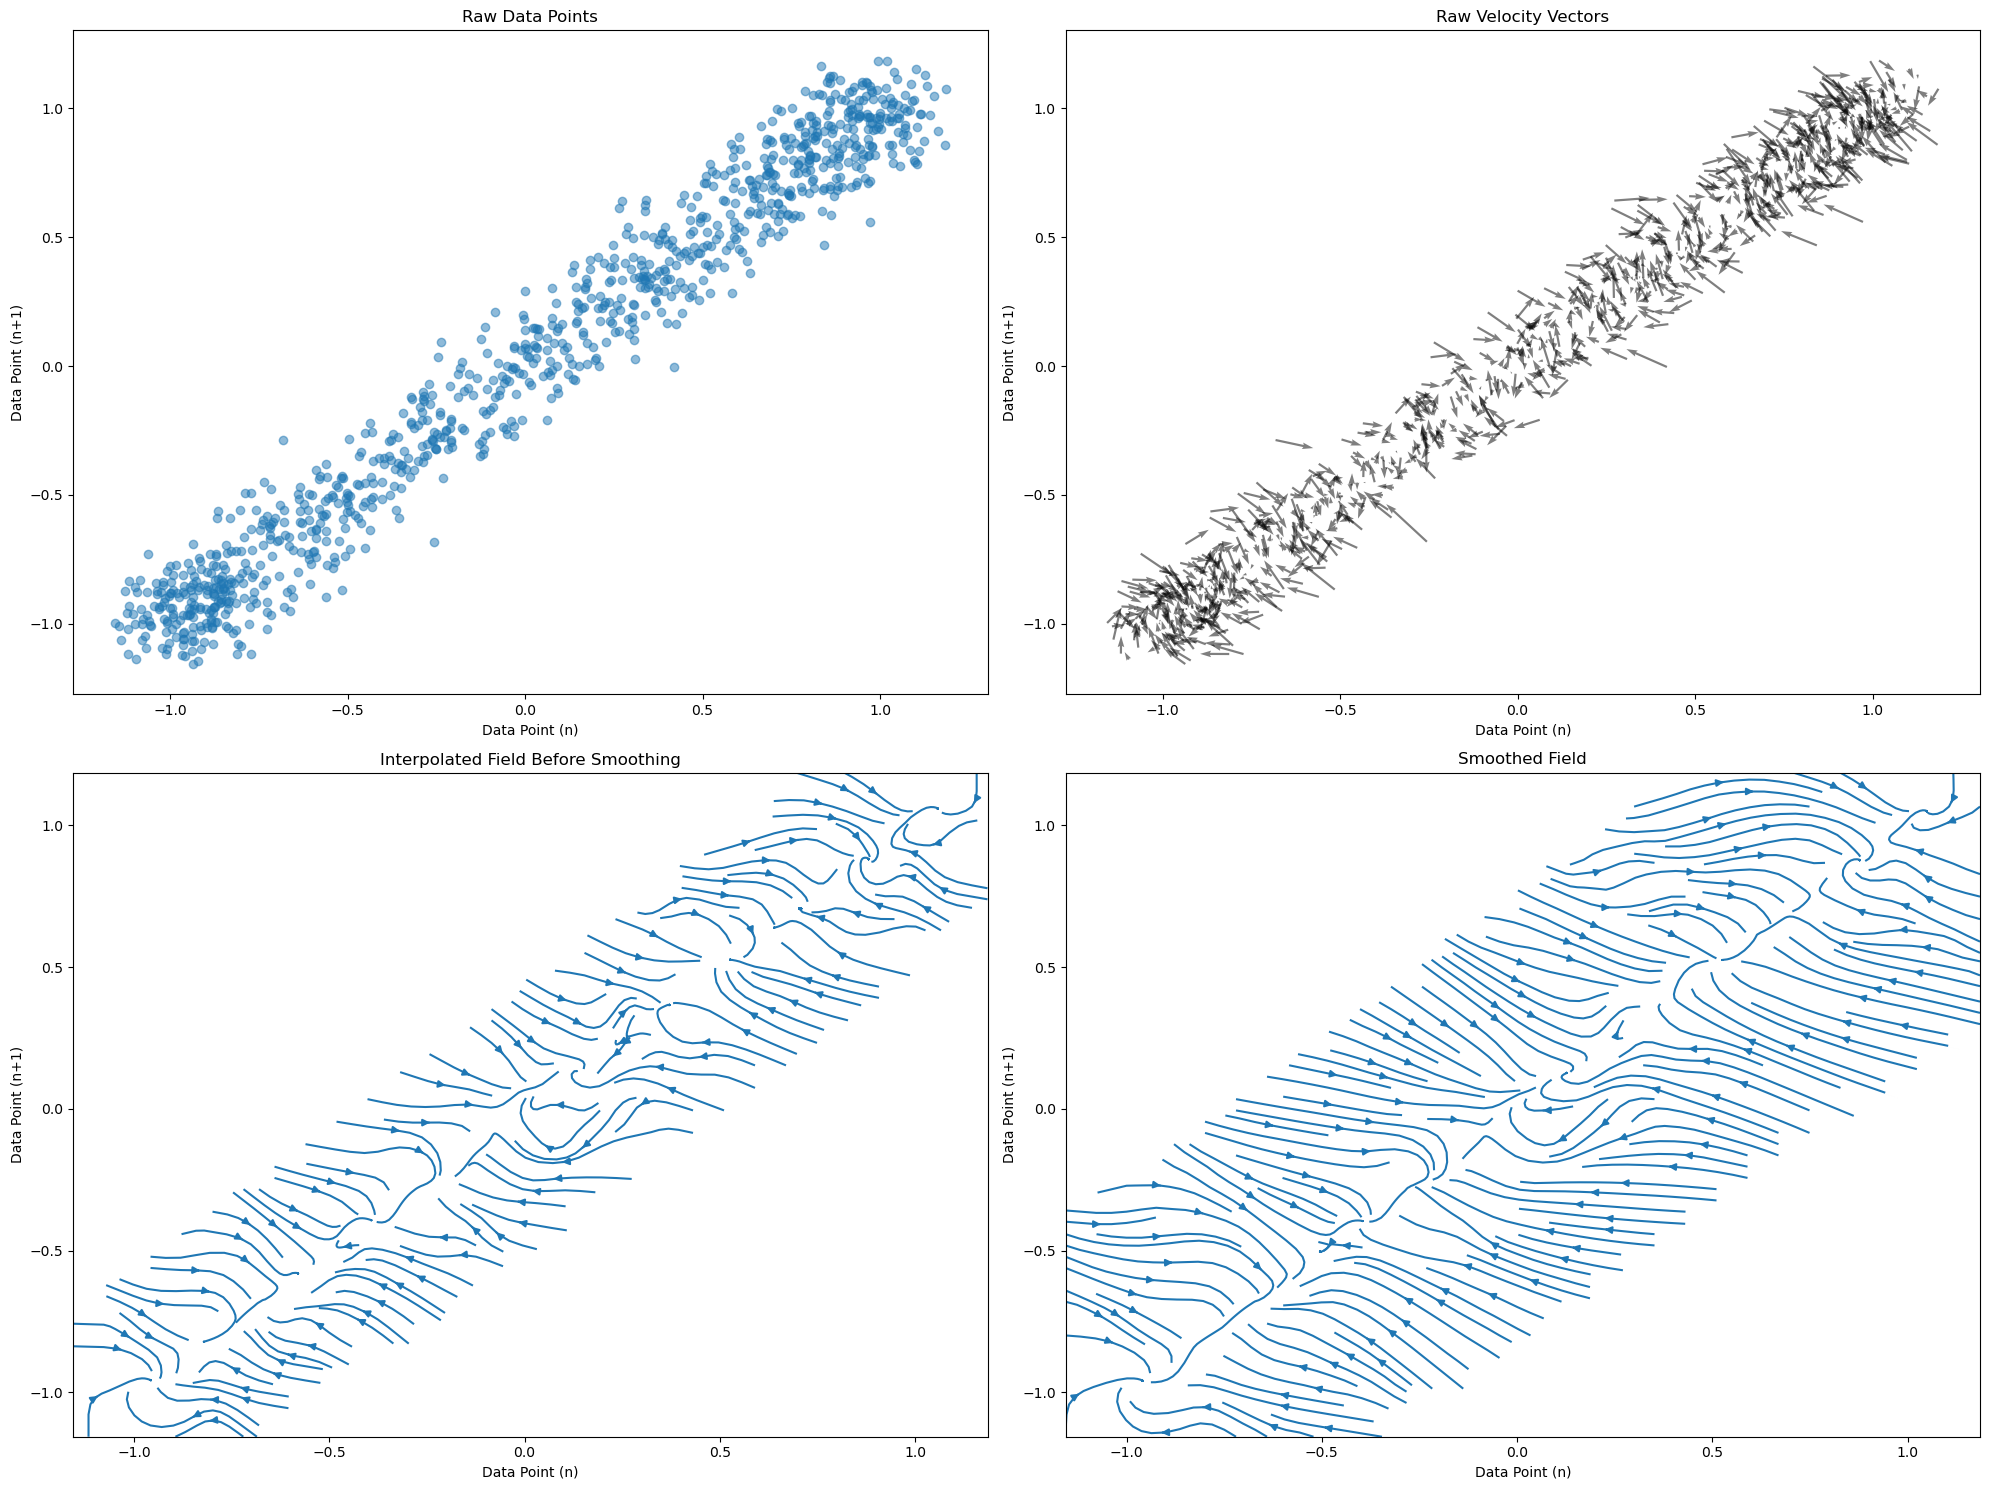

In [16]:
def visualize_processing_steps(data):
    # Create phase space points
    x, y = create_phase_space(data)
    
    # Calculate velocities
    dx = np.diff(x)
    dy = np.diff(y)
    
    # Create grid for interpolation
    grid_size = 30
    grid_x = np.linspace(min(x), max(x), grid_size)
    grid_y = np.linspace(min(y), max(y), grid_size)
    X, Y = np.meshgrid(grid_x, grid_y)
    
    # Interpolate velocities
    points = np.column_stack((x[:-1], y[:-1]))
    U_raw = griddata(points, dx, (X, Y), method='cubic', fill_value=0)
    V_raw = griddata(points, dy, (X, Y), method='cubic', fill_value=0)
    
    # Apply smoothing
    smoothing = 0.5
    U_smooth = gaussian_filter(U_raw, smoothing)
    V_smooth = gaussian_filter(V_raw, smoothing)
    
    # Create subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Raw data points
    plt.subplot(2, 2, 1)
    plt.scatter(x[:-1], y[:-1], alpha=0.5)
    plt.title("Raw Data Points")
    plt.xlabel("Data Point (n)")
    plt.ylabel("Data Point (n+1)")
    
    # 2. Velocity vectors
    plt.subplot(2, 2, 2)
    plt.quiver(x[:-1], y[:-1], dx, dy, alpha=0.5)
    plt.title("Raw Velocity Vectors")
    plt.xlabel("Data Point (n)")
    plt.ylabel("Data Point (n+1)")
    
    # 3. Interpolated field
    plt.subplot(2, 2, 3)
    plt.streamplot(X, Y, U_raw, V_raw, density=2)
    plt.title("Interpolated Field Before Smoothing")
    plt.xlabel("Data Point (n)")
    plt.ylabel("Data Point (n+1)")
    
    # 4. Smoothed field
    plt.subplot(2, 2, 4)
    plt.streamplot(X, Y, U_smooth, V_smooth, density=2)
    plt.title("Smoothed Field")
    plt.xlabel("Data Point (n)")
    plt.ylabel("Data Point (n+1)")
    
    plt.tight_layout()
    return plt

visualize_processing_steps(data)

The Flow Field visualization extends beyond individual trajectories by transforming time series data into a comprehensive vector field that represents the typical direction and magnitude of movement between consecutive points throughout the entire phase space. By calculating velocity vectors between sequential data points and then interpolating these vectors across regions with sparse or no data, the flow field reveals the underlying "force" patterns that govern how the system typically evolves from any given state. When rendered as streamlines, this visualization exposes critical dynamical features such as stable attractors (where streamlines converge), repellers (where streamlines diverge), saddle points (transition regions between different attractors), and basins of attraction (regions where all trajectories lead to the same attractor). Researchers analyzing psychological or behavioral data can use flow fields to identify the fundamental structure of the system's dynamics, predict likely future states from current conditions, and understand the "landscape" that constrains the system's behavior. The smoothing applied to the interpolated field helps reveal the general tendencies rather than getting caught in the noise of individual transitions, making it especially valuable for understanding complex, noisy time series where the underlying structure might otherwise remain hidden.

## Joint Interval Distribution Animation

In [21]:
def create_interval_animation(data, output_filename='interval_animation.gif', 
                             window_size=200, step_size=50, bins=20, fps=5):
    """
    Creates and saves an animation showing the evolution of joint interval distributions.
    
    Parameters:
    -----------
    data : array-like
        The time series data to analyze
    output_filename : str, default='interval_animation.gif'
        Filename for the saved animation
    window_size : int, default=200
        Size of the sliding window
    step_size : int, default=50
        Step size for advancing the window (for overlapping windows)
    bins : int, default=20
        Number of bins for the 2D histogram
    fps : int, default=5
        Frames per second in the output animation
        
    Returns:
    --------
    None : Saves the animation to the specified output file
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.animation import FuncAnimation
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Function to update the plot for each frame
    def update(frame):
        ax.clear()
        start = frame * step_size
        end = start + window_size
        
        # Create 2D histogram
        hist, xedges, yedges = np.histogram2d(
            data[start:end-1],
            data[start+1:end],
            bins=bins
        )
        
        # Plot the 2D histogram
        im = ax.imshow(hist.T, origin='lower', aspect='auto',
                      extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                      cmap='viridis')
        ax.set_title(f'Joint Interval Distribution (Window {frame+1})')
        ax.set_xlabel('Current interval value')
        ax.set_ylabel('Next interval value')
        return [im]
    
    # Create the animation
    frames = (len(data) - window_size) // step_size
    anim = FuncAnimation(fig, update, frames=frames, interval=200, blit=True)
    
    # Save the animation as a GIF
    anim.save(output_filename, writer='pillow', fps=fps)
    plt.close(fig)

In [22]:
# Use the function
create_interval_animation(data, output_filename='jid.gif')

In [27]:
## Joint Interval Distribution

def visualize_consecutive_values(data, bins=30, figsize=(12, 7), show_plot=True):
    """
    Visualizes the relationship between consecutive values in a data array.
    
    Parameters:
    -----------
    data : ndarray
        Numpy array containing the time series data
    bins : int, default=30
        Number of bins for the 2D histogram
    figsize : tuple, default=(12, 7)
        Figure size for the plot
    show_plot : bool, default=True
        Whether to display the plot immediately
        
    Returns:
    --------
    Figure or None:
        - The matplotlib Figure object (if show_plot is False)
        - None (if show_plot is True)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Create the figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a 2D histogram / heatmap
    hist, xedges, yedges = np.histogram2d(data[:-1], data[1:], bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(hist.T, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    
    ax.set_xlabel('Current value')
    ax.set_ylabel('Next value')
    ax.set_title('Relationship between consecutive data points')
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Frequency')
    
    # Show plot if requested
    # This part of the code prevents the plot being printed twice
    if show_plot:
        plt.show()
        return None
    else:
        return fig

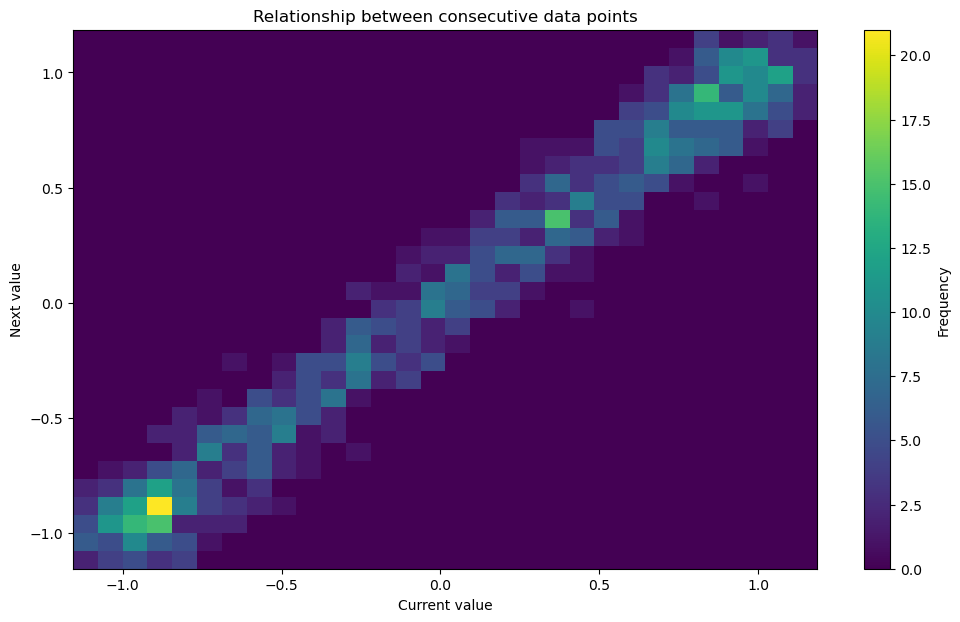

In [29]:
# Use the function -> avoid duplicate plots
fig = visualize_consecutive_values(data, show_plot=False)
plt.show()

The Joint Interval Distribution (JID) visualization quantifies the statistical relationships between consecutive values in a time series by creating a 2D histogram that maps transition frequencies, with the current value on one axis and the subsequent value on the other. Unlike the previous visualizations that focus on trajectories and dynamics, the JID reveals the probability structure of transitions, with bright areas indicating frequently occurring transitions and dark areas showing rare or impossible transitions in the system's evolution. This visualization is particularly powerful for identifying multimodal dynamics, where the system has multiple distinct behavioral states, as these appear as separate "islands" or clusters of high intensity in the distribution. Researchers can use the JID to quantify the predictability of state transitions, identify the most likely next states from any given current state, and detect subtle patterns that might indicate underlying mechanisms in psychological or physiological processes. The animated version of the JID using a sliding window approach further enhances this by revealing how these transition probabilities themselves change over time, allowing researchers to identify non-stationary processes and temporal shifts in behavioral patterns that static analyses would miss.